In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, datetime, timedelta

import os

### Object of ETF Data

In [2]:
class EquitiesPF():

    def __init__(self, index_etf, symbollist, etf_path, symbol_path, startdate='2011-01-03', enddate='2018-12-31'):
        self.index_etf = index_etf
        self.symbollist = symbollist
        self.etf_path = self.join_path(etf_path)
        self.symbol_path = self.join_path(symbol_path)
        self.startdate = startdate
        self.enddate = enddate
        self.data_dict = self.get_data_dict()
        
    def join_path(self, *args):
        yahoo_path = os.path.join('D:\\', 'Trading', 'Data', 'eod_yahoofinance')
        return os.path.join(yahoo_path, *args)
    
    def get_data_dict(self):
        """Create dictionary matching each symbol with historical prices dataframe."""
        price_dict = dict()
        # Set the data columns of each Yahoo Finance Dataframe
        columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Collect the index ETF data into the data dict
        df_index = pd.read_csv(self.join_path(self.etf_path, self.index_etf + '.csv'), header=0, index_col='date', parse_dates=True)
        df_index = df_index.loc[self.startdate:self.enddate]
        df_index.columns = columns
        price_dict[self.index_etf] = df_index
        
        # Collect each symbol data into the data dict
        for symbol in self.symbollist:
            df = pd.read_csv(self.join_path(self.symbol_path, symbol + '.csv'), header=0, index_col='date', parse_dates=True)
            df.fillna(method='ffill', inplace=True)           
            df = df.loc[self.startdate:self.enddate]
            df.columns = columns
            price_dict[symbol] = df
        
        return price_dict
    
    def get_normed_price(self):
        """Get dataframe of index ETF daily return and another dataframe of daily return of each symbol"""
        df_normed_index = self.data_dict[self.index_etf].loc[:, ['Close']] / self.data_dict[self.index_etf].loc[:, 'Close'][0]
        df_normed_index.columns = [self.index_etf]
        df_normed_symbols = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_normed_symbols[symbol] = self.data_dict[symbol].loc[:, 'Close'] / self.data_dict[symbol].loc[:, 'Close'][0]
        
        return df_normed_index, df_normed_symbols
    
    def pf_weight(self, weight):
        """Get the daily percentage return of each symbol, the portfolio and the benchmark index ETF."""
        assert weight.min() >= 0, 'Input weight vector has negative weight!'
        assert len(weight) == len(self.symbollist), 'Length of weight vector does NOT match!'
        df_normed_index, df_normed_pf = self.get_normed_price()
        df_normed_pf['Portfolio'] = df_normed_pf.mul(weight, axis=1).sum(axis=1)
        df_normed_pf['Benchmark'] = df_normed_index

        # Percentage return for each symbol and the weighted portfolio
        df_pct_pf = df_normed_pf.pct_change()

        return df_normed_pf, df_pct_pf
    
    def pf_cov(self, weight):
        """Compute the asset corrleation & covariance and also with the portfolio and benchmark."""
        df_normed_df, df_pct_pf = self.pf_weight(weight)
        cov_symbols = df_pct_pf.cov()
        corr_symbols = df_pct_pf.corr()
        return cov_symbols, corr_symbols
    
    def pf_perform_KPI(self, weight):
        """Get the performance KPI from the time series of percentage or logarithmic daily return."""
        df_normed_pf, df_pct_pf = self.pf_weight(weight)
        cov_symbols, corr_symbols = self.pf_cov(weight)
        df_log_pf = np.log(df_pct_pf.add(1))
        df_kpi = pd.DataFrame(columns=df_log_pf.columns)
        row_label = pd.Series(['mean_return', 'sigma', 'sharpe_ratio', 'MDD', 'beta'])
        for asset in df_kpi.columns:
            df_kpi[asset] = [df_log_pf[asset].mean(),   # Mean daily log return 
                             df_log_pf[asset].std(),    # SD of daily log return
                             df_log_pf[asset].mean() / df_log_pf[asset].std() * np.sqrt(252),   # Sharpe Ratio
                             (df_normed_pf[asset] / df_normed_pf[asset].cummax()).min() - 1,       # MDD
                             cov_symbols.loc[asset, 'Benchmark'] / cov_symbols.loc['Benchmark', 'Benchmark'] ]
        df_kpi.set_index(row_label, inplace=True)
                
        return df_kpi

In [3]:
# US Sector ETF list 
sectorlist = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'VNQ', 'TLT', 'GLD']
index_etf = 'VOO'
etf_path = 'ETF_adjusted'

USetf = EquitiesPF(index_etf, sectorlist, etf_path, etf_path)
etf_dict = USetf.data_dict

# The normed index of each ETF (with prices on 2-Jan-2011 set as 1.0000)
df_voo, df_sector = USetf.get_normed_price()
df_sector.tail(10)

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD
date,,,,,,,,,,,,
2018-12-17,1.528317,1.062240,2.736184,2.199751,2.830027,2.232322,2.318966,3.120086,2.949398,1.886026,1.592284,0.854130
2018-12-18,1.536801,1.037148,2.725923,2.210759,2.852417,2.205906,2.303363,3.092890,2.972466,1.905465,1.601820,0.856159
2018-12-19,1.515894,1.024950,2.691721,2.169065,2.795995,2.184522,2.299568,3.052453,2.913614,1.884550,1.622981,0.850942
2018-12-20,1.495594,0.996547,2.667780,2.129373,2.745843,2.145528,2.298303,3.009511,2.848256,1.856253,1.617088,0.864058
2018-12-21,1.482144,0.986873,2.614435,2.089167,2.662417,2.123271,2.288478,2.972126,2.783710,1.830418,1.616821,0.860290
2018-12-24,1.443718,0.946948,2.559370,2.025066,2.591360,2.061918,2.192788,2.900950,2.730862,1.765212,1.624856,0.869710
2018-12-26,1.508372,1.005869,2.675236,2.119372,2.747866,2.119463,2.222558,3.027485,2.892671,1.824266,1.607445,0.867101
2018-12-27,1.536124,1.011145,2.707357,2.145885,2.767655,2.139774,2.241271,3.060916,2.908110,1.824020,1.607713,0.873696
2018-12-28,1.527890,1.003406,2.706210,2.140180,2.761359,2.139774,2.246800,3.064511,2.908407,1.829925,1.621240,0.877246


In [4]:
eqweight = np.repeat(1/len(sectorlist), len(sectorlist))
df_pct_sector = USetf.pf_weight(eqweight)
df_kpi = USetf.pf_perform_KPI(eqweight)
df_kpi

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,Portfolio,Benchmark
mean_return,0.000215,0.000004,0.000500,0.000383,0.000510,0.000380,0.000403,0.000564,0.000536,0.000302,0.000242,-0.000064,0.000365,0.000420
sigma,0.011825,0.013706,0.013608,0.010601,0.010501,0.007487,0.008835,0.009479,0.010028,0.010704,0.008595,0.009963,0.007178,0.009157
sharpe_ratio,0.288545,0.004979,0.583124,0.574013,0.770610,0.806419,0.724801,0.944783,0.848812,0.447631,0.447266,-0.102523,0.808118,0.727971
MDD,-0.294984,-0.467452,-0.336773,-0.258383,-0.237849,-0.161044,-0.156900,-0.173344,-0.213715,-0.226337,-0.206588,-0.455550,-0.158385,-0.194768
beta,1.136857,1.171876,1.193130,1.078658,1.052033,0.631205,0.484799,0.894107,1.011133,0.822203,-0.446120,-0.034453,0.759626,1.000000


### Correlation & Covariance of returns

- Notice that TLT has negative beta and hence negative correlation with SPY 
- Utilities Sector has least beta among all sector ETFs

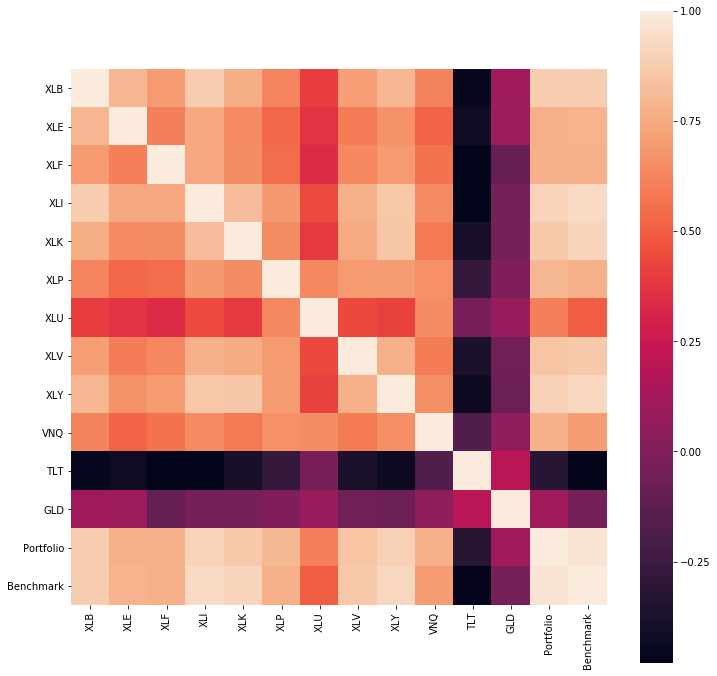

In [5]:
import seaborn as sns

cov_pf, corr_pf = USetf.pf_cov(eqweight)

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_pf, square=True, ax=ax)

## Portfolio Optimizer 

In [6]:
class PFOptimizer():
    
    def __init__(self, symbollist, normed_pf, normed_index, rand_size=2500, startdate='2011-01-03', enddate='2018-12-31'):
        self.symbollist = symbollist
        self.startdate = startdate
        self.enddate = enddate
        self.normed_pf = normed_pf
        self.normed_index = normed_index
        self.rand_size = rand_size
        self.rand_weight = self.get_random_weight()
        
    def get_random_weight(self):
        """Generate random weights from uniform distribution and store them into ."""
        df_weight = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_weight[symbol] = np.random.uniform(size=self.rand_size)
        df_weight = df_weight.div(df_weight.sum(axis=1), axis=0)
        
        return df_weight
        
    def randweight_kpi(self, normed_pf, normed_index):
        """Compute KPI's such as mean return, sigma for each randomized portfilio."""
        # Create empty dataframe with the desired KPI as column names
        kpi_columns = ['mean%', 'sigma%', 'sharpe', 'beta']
        df_kpi = pd.DataFrame(columns=kpi_columns)
        index_return = np.log(normed_index.pct_change() + 1)
        # For loop to compute the KPI
        for num in range(self.rand_size):
            weight = self.rand_weight.iloc[num, :]
            df_portfolio = normed_pf.mul(weight, axis=1).sum(axis=1)
            log_return = np.log(df_portfolio.pct_change() + 1)
            log_mean = 100 * log_return.mean()                  # Average daily log return
            log_sd = 100 * log_return.std()                     # Average daily SD
            sharpe = log_mean / log_sd * np.sqrt(252)           # Sharpe Ratio
            cov_random = pd.concat([pd.DataFrame(log_return, columns=['portfolio']), index_return], axis=1).cov()
            beta = cov_random.iloc[0, 1] / cov_random.iloc[1, 1]    # beta
            df_kpi = df_kpi.append({'mean%': log_mean, 'sigma%': log_sd, 'sharpe': sharpe, 'beta': beta}, 
                                   ignore_index=True)
            
        df_kpi = pd.concat([self.rand_weight, df_kpi], axis=1)    
        
        return df_kpi
            
    
    def train_test_split(self, train_end):
        """Split the dataset into training set and test set, with normed prices in each of two datasets."""
        
        # Split the normed_pf and normed_index dataframes into two halves
        train_pf = self.normed_pf.loc[self.startdate:train_end]
        train_index = self.normed_index.loc[self.startdate:train_end]
        test_pf = self.normed_pf.loc[train_end:]
        test_index = self.normed_index.loc[train_end:]
        
        # Normalize the test datasets
        test_pf = test_pf / test_pf.iloc[0, :]
        test_index = test_index / test_index.iloc[0, :]      
        
        # KPI dataframes for training datasets & test datasets
        train_kpi = self.randweight_kpi(train_pf, train_index)
        test_kpi = self.randweight_kpi(test_pf, test_index)
        
        return train_kpi, test_kpi
    
    

### Simulate 2500 portfolios

In [7]:
from time import time

start_time = time()

size = 2500
Etfopt = PFOptimizer(sectorlist, df_sector, df_voo, rand_size=size)
df_weight = Etfopt.rand_weight
df_kpi = Etfopt.randweight_kpi(df_sector, df_voo)

print('Mean Sharpe: ', df_kpi['sharpe'].mean())
print('Max Sharpe: ',  df_kpi['sharpe'].max())
print('Mean CAGR: ', df_kpi['mean%'].mean() * 252)
print('Max CAGR: ', df_kpi['mean%'].max() * 252)
print('Mean Sigma: ' , df_kpi['sigma%'].mean() * np.sqrt(252))
print('Min Sigma: ' , df_kpi['sigma%'].min() * np.sqrt(252))
print('Average beta: ', df_kpi['beta'].mean())


print('\nTime elapsed: ', time() - start_time)

Mean Sharpe:  0.8010601722932047
Max Sharpe:  1.07327293162402
Mean CAGR:  9.197990225372378
Max CAGR:  11.563908593983866
Mean Sigma:  11.541132252990996
Min Sigma:  8.303022353425046
Average beta:  0.7593635724642619

Time elapsed:  9.827836275100708


### Sorting with Sharpe ratios, mean return & volatility

In [8]:
# Portfolio with max sharpe
maxsharpe_row = df_kpi['sharpe'].idxmax()
maxsharpe_df = df_weight.iloc[[maxsharpe_row], :]

# Portfolio with max return
maxreturn_row = df_kpi['mean%'].idxmax()
maxreturn_df = df_weight.iloc[[maxreturn_row], :]

# Portfolio with min volatility
minvol_row = df_kpi['sigma%'].idxmin()
minvol_df = df_weight.iloc[[minvol_row], :]

df_optpf = pd.concat([maxsharpe_df, maxreturn_df, minvol_df], axis=0)
df_optpf.index = ['max_sharpe', 'max_return', 'min_vol']
df_optpf

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD
max_sharpe,0.009875,0.013292,0.088859,0.017386,0.056214,0.098725,0.199120,0.159160,0.009567,0.110126,0.196277,0.041399
max_return,0.012379,0.002769,0.252583,0.089627,0.105805,0.007832,0.131238,0.038882,0.219642,0.103220,0.021129,0.014894
min_vol,0.101329,0.024643,0.028259,0.000927,0.126931,0.203111,0.149576,0.014448,0.007428,0.020639,0.222485,0.100222


In [9]:
# Sort the portfolios by Sharpe ratio (descending order)

df_sort_sharpe = df_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
df_sort_sharpe.reset_index(inplace=True)
df_sort_sharpe.drop('index', axis=1, inplace=True)

# Top 1% Sharpe-ratio portfolio
df_sort_sharpe.head(size//100)


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.009875,0.013292,0.088859,0.017386,0.056214,0.098725,0.199120,0.159160,0.009567,0.110126,0.196277,0.041399,0.039363,0.582215,1.073273,0.537826
1,0.014296,0.003223,0.108213,0.112470,0.000244,0.040797,0.106132,0.095552,0.181056,0.007263,0.168064,0.162690,0.038075,0.587918,1.028063,0.580281
2,0.003354,0.019691,0.054537,0.106499,0.038823,0.149001,0.114103,0.183458,0.075671,0.025070,0.134164,0.095629,0.039898,0.617128,1.026298,0.623566
3,0.048448,0.010902,0.119924,0.118423,0.067826,0.108718,0.029370,0.119843,0.054438,0.011583,0.206804,0.103722,0.037826,0.587794,1.021572,0.587794
4,0.011678,0.014018,0.101909,0.002415,0.052413,0.202509,0.037501,0.212269,0.025120,0.112174,0.143139,0.084854,0.039852,0.624735,1.012649,0.620861
5,0.043575,0.034077,0.035291,0.120967,0.074502,0.211836,0.059184,0.124360,0.036328,0.034128,0.187668,0.038085,0.038075,0.597489,1.011609,0.602165
6,0.029947,0.013771,0.061660,0.055525,0.101356,0.133741,0.162143,0.057439,0.167704,0.007298,0.123922,0.085493,0.040217,0.631286,1.011315,0.645752
7,0.009254,0.008278,0.123071,0.024631,0.085055,0.098771,0.147033,0.135156,0.090851,0.107869,0.132346,0.037685,0.041980,0.659402,1.010636,0.671141
8,0.039820,0.055529,0.060917,0.007712,0.101165,0.042875,0.088137,0.214914,0.170003,0.014720,0.144475,0.059732,0.042607,0.670397,1.008898,0.697686
9,0.003101,0.032200,0.071926,0.006063,0.146032,0.128365,0.124205,0.133471,0.149243,0.042227,0.109905,0.053262,0.042829,0.674027,1.008706,0.702901


### Average weights of top 1% Sharpe-ratio portfolios (with pie chart)

In [10]:
# Average weights & Sharpe ratio of the top 1% portfolios

top_sharpe = pd.DataFrame(df_sort_sharpe.head(25).mean()).transpose()
top_sharpe


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.030806,0.024995,0.084697,0.063303,0.093967,0.092327,0.11202,0.120222,0.097827,0.054534,0.161539,0.063762,0.039909,0.632113,1.002866,0.637884


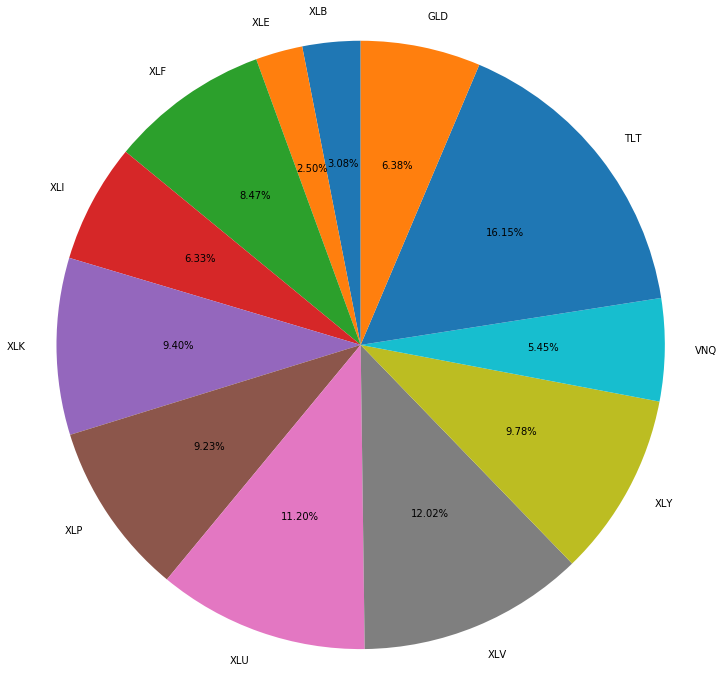

In [11]:
labels = USetf.symbollist
pct = top_sharpe.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [12]:
# Average weights & Sharpe ratio of the top 1% return portfolios

df_sort_return = df_kpi.sort_values(['mean%', 'sharpe'], ascending=False)
df_sort_return.reset_index(inplace=True)
df_sort_return.drop('index', axis=1, inplace=True)

top_return = pd.DataFrame(df_sort_return.head(100).mean()).transpose()
top_return

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.053156,0.032993,0.111792,0.081993,0.119604,0.080703,0.093145,0.133763,0.12213,0.080008,0.059944,0.030769,0.042703,0.781843,0.87126,0.830257


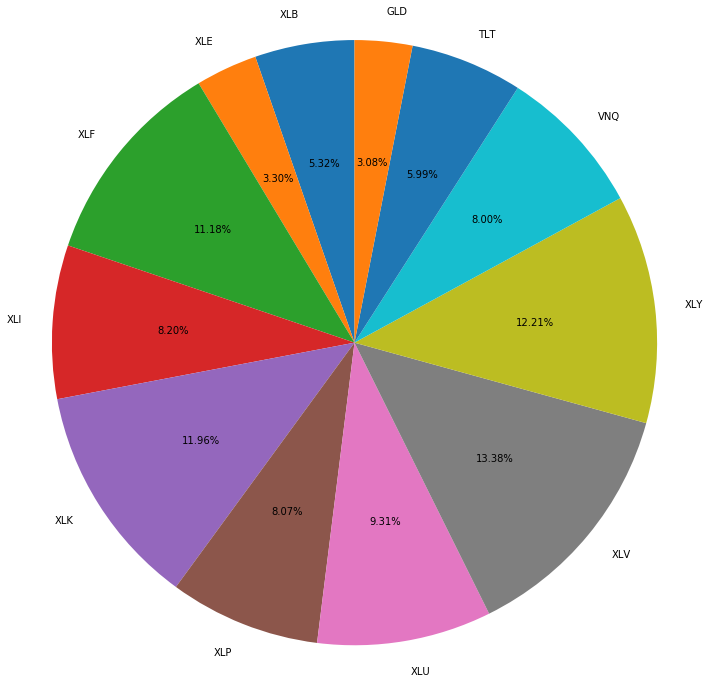

In [13]:
labels = USetf.symbollist
pct = top_return.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [14]:
# Average weights & Sharpe ratio of the top 1% return portfolios

df_sort_sigma = df_kpi.sort_values(['sigma%'], ascending=True)
df_sort_sigma.reset_index(inplace=True)
df_sort_sigma.drop('index', axis=1, inplace=True)

min_vol = pd.DataFrame(df_sort_sigma.head(100).mean()).transpose()
min_vol

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.063006,0.063425,0.063329,0.062199,0.067993,0.094988,0.101674,0.058231,0.064025,0.071878,0.162324,0.126928,0.033587,0.598924,0.890782,0.584086


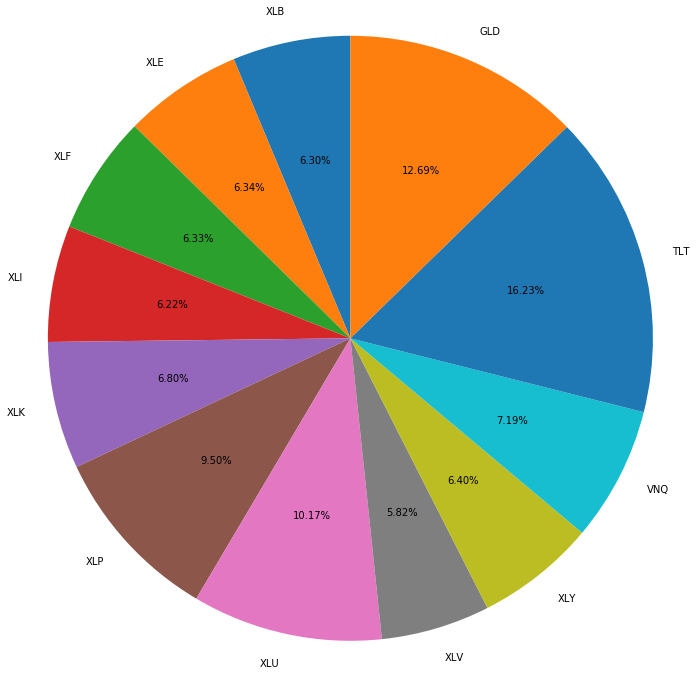

In [15]:
labels = USetf.symbollist
pct = min_vol.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

### Scatter Plot & Optimal Portfolios

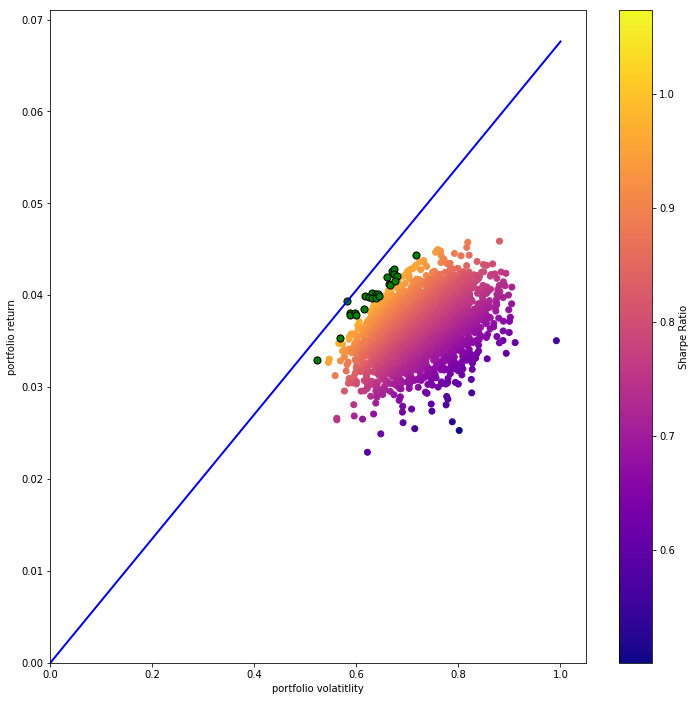

In [16]:
# Scatter plot of all (sigma, return)-tuple of the 10000 portfolios 
plt.figure(figsize=(12,12))
fig = plt.scatter(df_sort_sharpe['sigma%'], df_sort_sharpe['mean%'], c=df_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(df_sort_sharpe.head(size//100)['sigma%'], df_sort_sharpe.head(size//100)['mean%'], c='green', s=50, edgecolors='black')

# Add straight line of optimal portfolio
xline = np.linspace(0, 1.0, 500)
yline = df_sort_sharpe['sharpe'][0] * xline / np.sqrt(252)
plt.plot(xline, yline, 'b-', linewidth=2)

plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

## Train-test-split on asset weights

- Split the dataset into two equal halves
- Find the top 1% sharpe-ratio portfolios on training set (2011-2014)
- Verify the respective (sigma, return)-tuple on test set (2015-2018)


In [17]:
train_kpi, test_kpi = Etfopt.train_test_split('2014-12-31')
train_kpi.head()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,VNQ,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.070756,0.155863,0.154803,0.168702,0.062512,0.043094,0.110549,0.014094,0.065130,0.003103,0.031809,0.119587,0.042723,0.851114,0.796854,0.854578
1,0.044484,0.087359,0.090449,0.107187,0.052642,0.094159,0.011293,0.154468,0.104615,0.013140,0.147778,0.092426,0.051724,0.655210,1.253176,0.646131
2,0.096808,0.095416,0.052249,0.091904,0.146519,0.036024,0.083289,0.035447,0.128726,0.094224,0.013395,0.125999,0.046043,0.843133,0.866897,0.848916
3,0.078204,0.051838,0.025739,0.132610,0.022264,0.076433,0.119106,0.006062,0.207691,0.064870,0.057644,0.157539,0.046390,0.725035,1.015710,0.709151
4,0.067745,0.038772,0.024484,0.029816,0.082058,0.111487,0.079125,0.078411,0.131104,0.118216,0.104262,0.134519,0.048860,0.647995,1.196962,0.624198


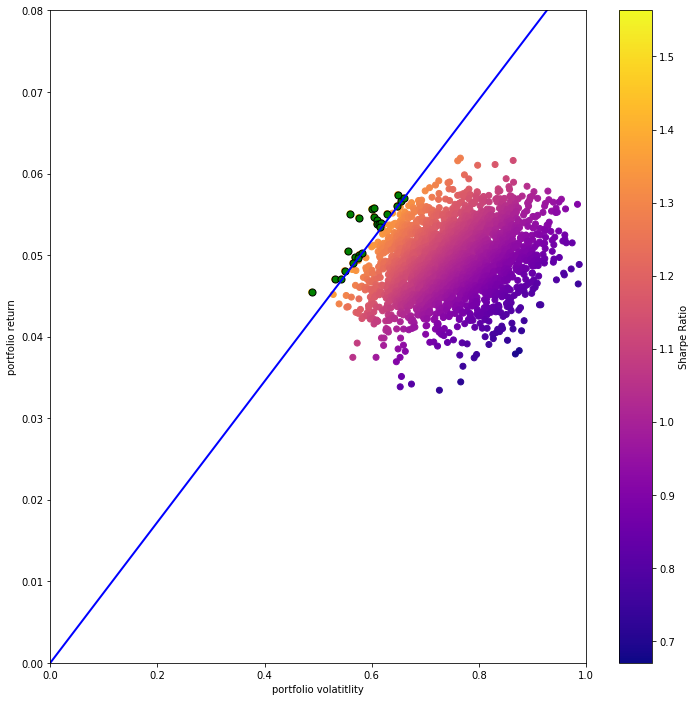

In [26]:
# Sort with descending Sharpe ratio and scatter plots 
train_sort_sharpe = train_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
train_sort_sharpe.reset_index(inplace=True)

plt.figure(figsize=(12,12))
fig = plt.scatter(train_sort_sharpe['sigma%'], train_sort_sharpe['mean%'], c=train_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(train_sort_sharpe.head(size//100)['sigma%'], train_sort_sharpe.head(size//100)['mean%'], c='green', s=50, edgecolors='black')

# Add straight line of optimal portfolio
xline = np.linspace(0, 1.0, 500)
yline = train_sort_sharpe['sharpe'][24] * xline / np.sqrt(252)
plt.plot(xline, yline, 'b-', linewidth=2)

plt.ylim(ymin=0)
plt.ylim(ymax=0.08)
plt.xlim(xmin=0)
plt.xlim(xmax=1.00)
plt.show()


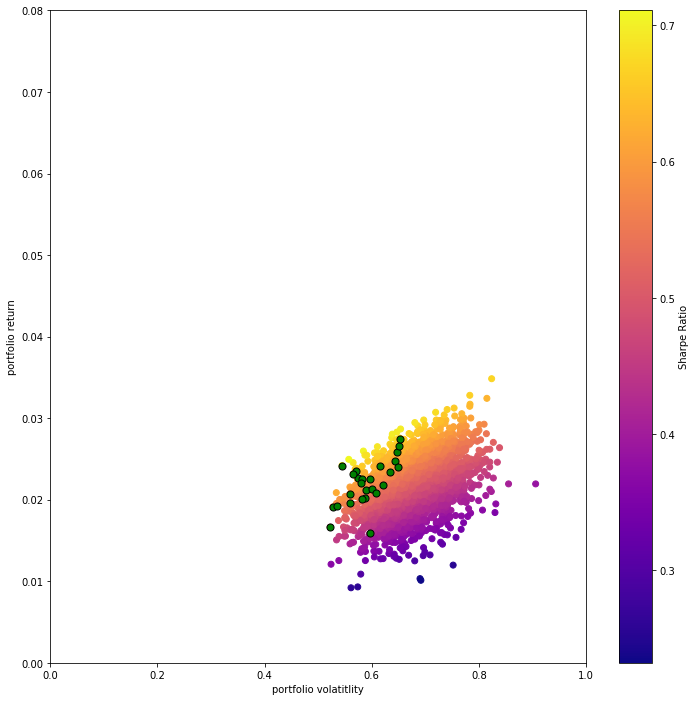

In [25]:
top_index = train_sort_sharpe.loc[0:size//100, 'index']

plt.figure(figsize=(12,12))
fig = plt.scatter(test_kpi['sigma%'], test_kpi['mean%'], c=test_kpi['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(test_kpi.loc[top_index, 'sigma%'], test_kpi.loc[top_index, 'mean%'], c='green', s=50, edgecolors='black')

plt.ylim(ymin=0)
plt.ylim(ymax=0.08)
plt.xlim(xmin=0)
plt.xlim(xmax=1.00)
plt.show()


In [132]:
pd.DataFrame(train_kpi.mean()).transpose()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.090548,0.091382,0.09015,0.090535,0.092417,0.090868,0.089513,0.091749,0.091489,0.089594,0.091755,0.048973,0.733758,1.072765,0.727939


In [133]:
pd.DataFrame(test_kpi.mean()).transpose()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,TLT,GLD,mean%,sigma%,sharpe,beta
0,0.090548,0.091382,0.09015,0.090535,0.092417,0.090868,0.089513,0.091749,0.091489,0.089594,0.091755,0.022743,0.677231,0.534742,0.742474
